In [5]:
numpize(img_path,(128, 128),grayscale=False)

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [10, 10, 10],
        [12, 12, 12],
        [14, 14, 14]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [58, 58, 58],
        [60, 60, 60],
        [60, 60, 60]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1],
        ...,
        [88, 88, 88],
        [80, 80, 80],
        [67, 67, 67]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [12, 12, 12],
        ...,
        [83, 83, 83],
        [85, 85, 85],
        [83, 83, 83]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [55, 55, 55],
        [57, 57, 57],
        [56, 56, 56]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

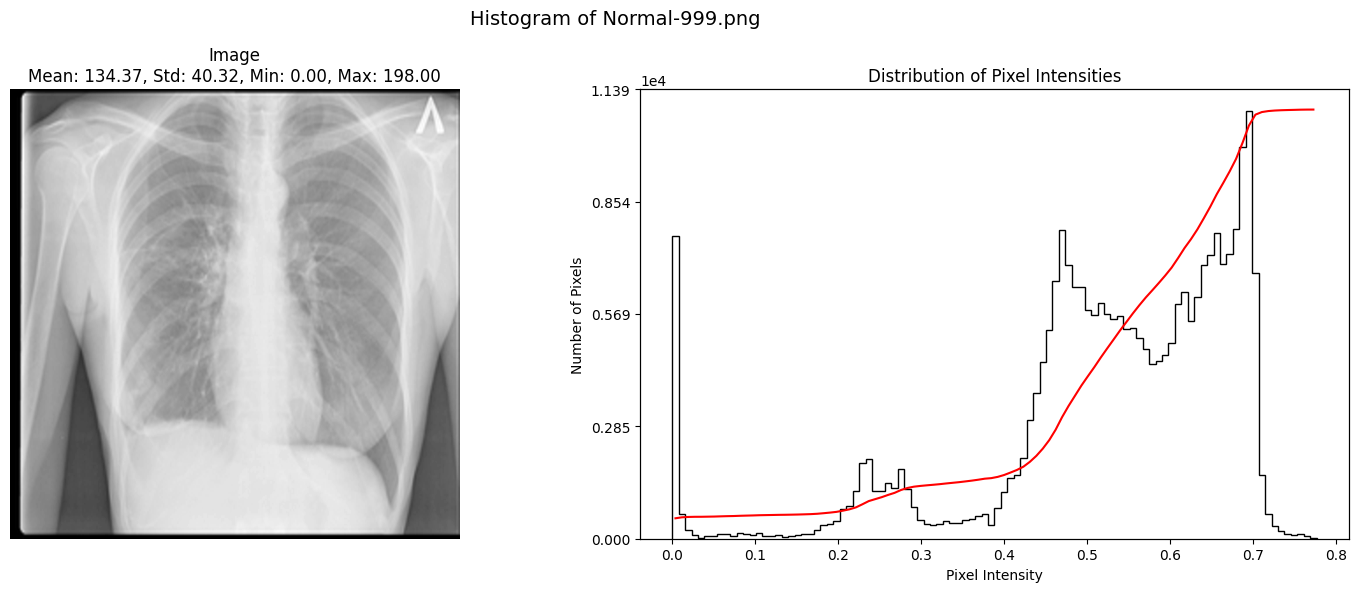

<Figure size 640x480 with 0 Axes>

In [7]:
from skimage import io

# Load the image
image = io.imread(img_path, as_gray=True)

# Call the function to plot the grayscale histogram
plot_gray_scale_histogram(image, "Histogram of Normal-999.png")

# Ensure the plot is fully rendered before saving
plt.tight_layout()

# Save the plot as an image

# Display the plot
plt.show()


In [8]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("trainedmodel.h5")

In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image
# Load an example image for prediction

# img_path = "C:/Users/prasa/Downloads/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-95.png"
# "C:\Users\prasa\Downloads\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-77.png"
img = image.load_img(img_path, target_size=(128, 128))  # Adjust the target size based on your model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Make a prediction
prediction = model.predict(img_array)
print(prediction)

# Print the prediction result
if prediction[0] >=0.8:
    print("Tuberculosis")
else:
    print("Normal")


1/1 [==============================] - 1s 509ms/step
[[0.94252586]]
Tuberculosis


1/1 [==============================] - 0s 37ms/step
Model Prediction: [[0.94252586]]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


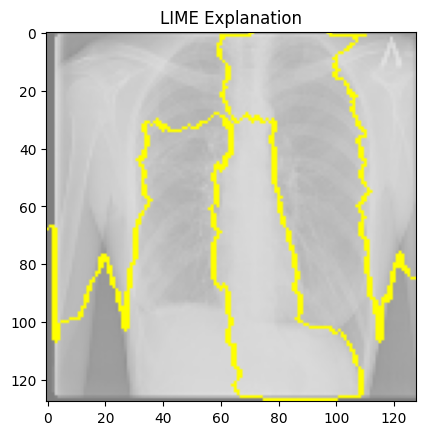

In [10]:
import numpy as np
from tensorflow.keras.preprocessing import image
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load an example image for prediction
img_path = img_path
img = image.load_img(img_path, target_size=(128, 128))  # Adjust the target size based on your model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Define LIME explainer for images
explainer = lime_image.LimeImageExplainer()

# Instantiate your CNN model (assuming you have already saved it)
# model = load_model("path_to_saved_model.h5")  # Load your saved model
# model.summary()

# Make predictions
prediction = model.predict(img_array)
print("Model Prediction:", prediction)

# Explain predictions for the image
explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

# Show the top regions contributing to the prediction
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.savefig("images_exp/lime_exp")
plt.show()


In [11]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 128, 128, 1)       28        
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 64, 64, 1)         0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 3)         30        
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 32, 32, 3)         0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 6)         168       
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 16, 16, 6)       

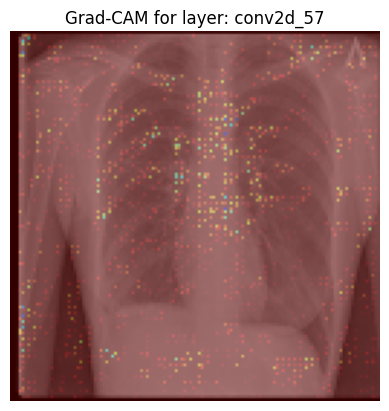

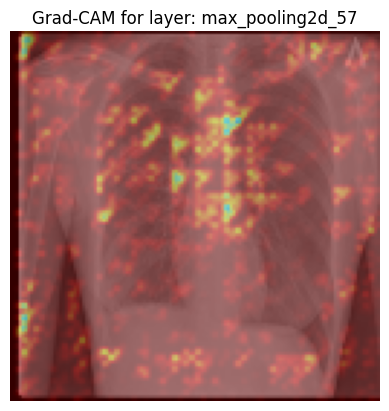

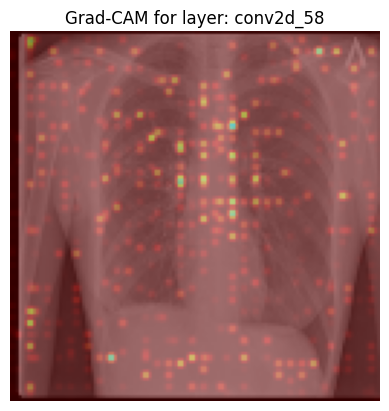

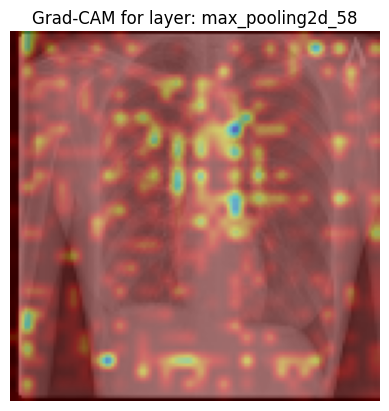

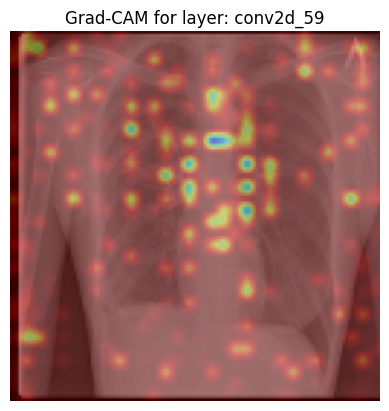

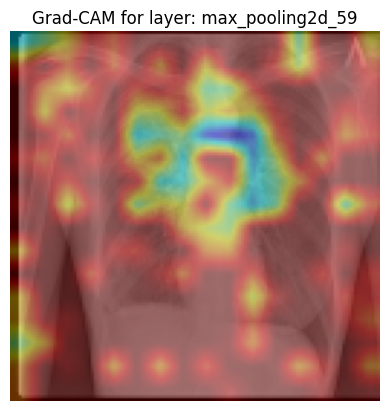

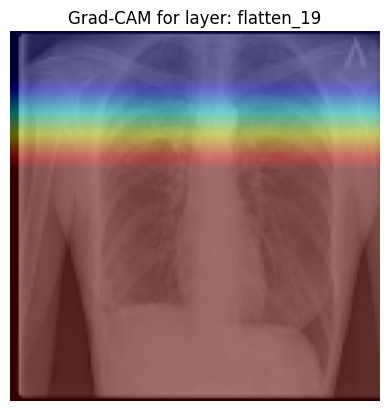

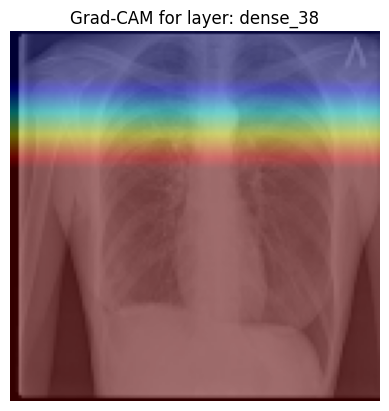

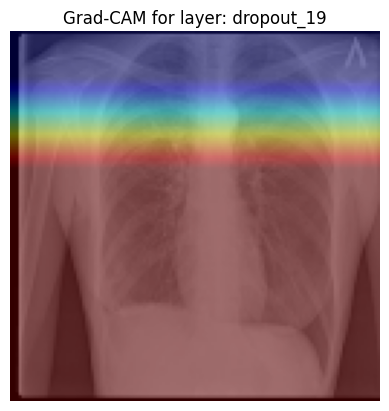

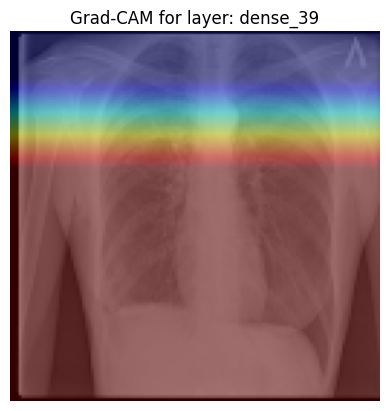

In [12]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute Grad-CAM for a specific layer
def compute_gradcam_for_layer(model, img_array, layer_name):
    # Create a gradient model
    gradient_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    # Calculate gradients
    with tf.GradientTape() as tape:
        last_conv_output, model_output = gradient_model(img_array)
        tape.watch(last_conv_output)
        tape.watch(model_output)
        pred_index = tf.argmax(model_output[0])
        output = model_output[:, pred_index]

    # Get the gradients
    grads = tape.gradient(output, last_conv_output)[0]

    # Compute the guided gradients
    guided_grads = (last_conv_output[0] * grads)

    # Get the heatmap
    heatmap = tf.reduce_mean(guided_grads, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend the heatmap with the original image
    superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)

    return superimposed_img

# Load an example image for prediction
  # Path to your image
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))  # Adjust the target size based on your model's input shape
img_array = np.expand_dims(img, axis=0) / 255.0  # Normalize the image

# Iterate over each layer and compute Grad-CAM
# model = your_model  # Replace 'your_model' with your actual model
layer_names = [layer.name for layer in model.layers]

for layer_name in layer_names:
    gradcam_img = compute_gradcam_for_layer(model, img_array, layer_name)
    plt.figure()
    plt.title(f'Grad-CAM for layer: {layer_name}')
    plt.imshow(gradcam_img)
    plt.axis('off')
    plt.savefig(f'images_exp/grad_cam_{layer_name}', bbox_inches='tight')


plt.show()




Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 128, 128, 1)       28        
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 64, 64, 1)         0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 3)         30        
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 32, 32, 3)         0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 6)         168       
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 16, 16, 6)       

c:\Python311\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
c:\Python311\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


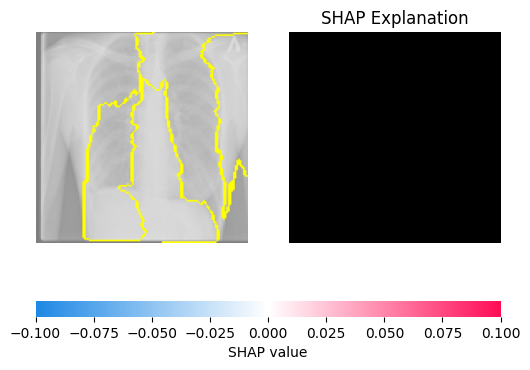

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load an example image for prediction
img_path = "static/lime_exp_993d94e4-ed83-493f-bb92-60384bba0fc1.png"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Instantiate your CNN model (assuming you have already saved it)
model = load_model("trainedmodel.h5")  # Load your saved model
model.summary()

# Create an explainer object using the DeepExplainer for TensorFlow Keras models
explainer = shap.DeepExplainer(model, img_array)

# Calculate SHAP values for the image
shap_values = explainer.shap_values(img_array)

# Plot the SHAP values
shap.image_plot(shap_values, img_array, show=False)
plt.title("SHAP Explanation")
plt.show()


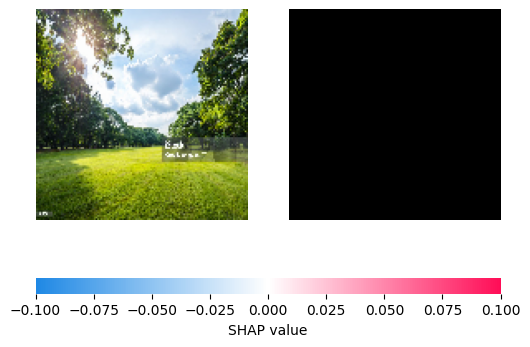

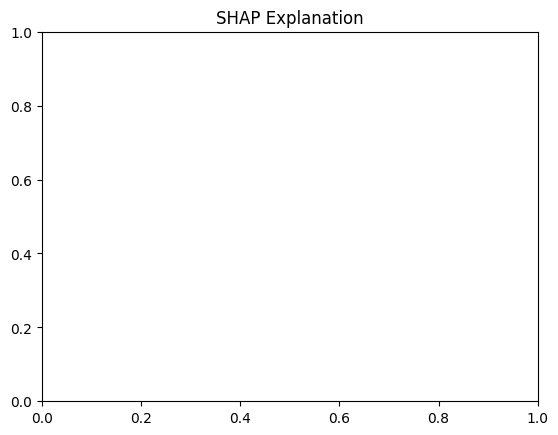

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load an example image for prediction
img_path = "image.png"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Load your trained model
model = load_model("trainedmodel.h5")

# Create an explainer object using the DeepExplainer for TensorFlow Keras models
explainer = shap.DeepExplainer(model, img_array)

# Calculate SHAP values for the image
shap_values = explainer.shap_values(img_array)

# Plot the SHAP values as a heatmap overlay on the input image
shap.image_plot(shap_values, img_array)
plt.title("SHAP Explanation")
plt.show()


32/32 [==============================] - 1s 8ms/step


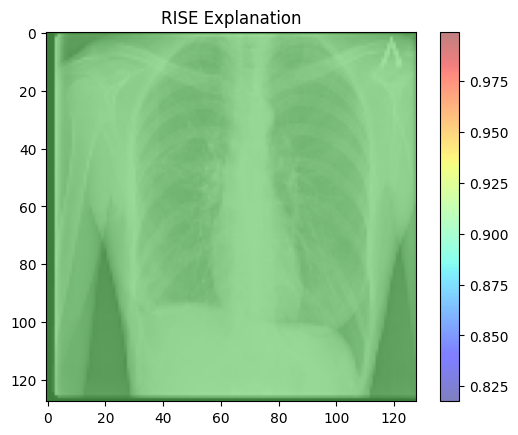

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load an example image for prediction
img_path = "Tuberculosis-71.png"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0  # Normalize the image

# Load your trained model
model = load_model("trainedmodel.h5")

# Function to generate perturbed images using RISE
def generate_perturbed_images(image, mask_size=8, n_masks=1000):
    perturbed_images = []
    for _ in range(n_masks):
        mask = np.random.choice([0, 1], size=(image.shape[0], image.shape[1]), p=[0.8, 0.2])
        masked_image = np.copy(image)
        masked_image[mask == 0] = 0
        perturbed_images.append(masked_image)
    return np.array(perturbed_images)

# Generate perturbed images using RISE
perturbed_images = generate_perturbed_images(img_array)

# Get model predictions for perturbed images
predictions = model.predict(perturbed_images)

# Aggregate predictions to obtain saliency map
saliency_map = np.mean(predictions, axis=0)

# Resize saliency map to match input image size
saliency_map = resize(saliency_map, img_array.shape[:2], anti_aliasing=True)

# Plot the input image with the saliency map overlay
plt.imshow(img_array)
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.title("RISE Explanation")
plt.colorbar()
plt.show()


32/32 [==============================] - 0s 7ms/step
[[0.7661715 ]
 [0.75962824]
 [0.7688198 ]
 [0.83580494]
 [0.8351791 ]
 [0.7687569 ]
 [0.7796411 ]
 [0.78168947]
 [0.8291912 ]
 [0.8512074 ]
 [0.8021352 ]
 [0.77206725]
 [0.78830683]
 [0.7613655 ]
 [0.75149816]
 [0.7820412 ]
 [0.8352527 ]
 [0.7343923 ]
 [0.80080384]
 [0.7693542 ]
 [0.76047355]
 [0.7419401 ]
 [0.78118825]
 [0.79466057]
 [0.7466636 ]
 [0.79771674]
 [0.80491966]
 [0.7798903 ]
 [0.83049273]
 [0.8272526 ]
 [0.76691324]
 [0.76249677]
 [0.7597048 ]
 [0.79188645]
 [0.7878877 ]
 [0.7732766 ]
 [0.809575  ]
 [0.7323246 ]
 [0.7259078 ]
 [0.79099995]
 [0.74750197]
 [0.7995705 ]
 [0.79889816]
 [0.8066314 ]
 [0.77022105]
 [0.79027885]
 [0.75967383]
 [0.78771675]
 [0.7349235 ]
 [0.7727222 ]
 [0.7302896 ]
 [0.8211768 ]
 [0.8063401 ]
 [0.7438056 ]
 [0.7191768 ]
 [0.7206305 ]
 [0.7551563 ]
 [0.7937389 ]
 [0.7991251 ]
 [0.7889459 ]
 [0.81594896]
 [0.78210443]
 [0.8167225 ]
 [0.7974011 ]
 [0.7811419 ]
 [0.8316717 ]
 [0.78704876]
 [0.77040

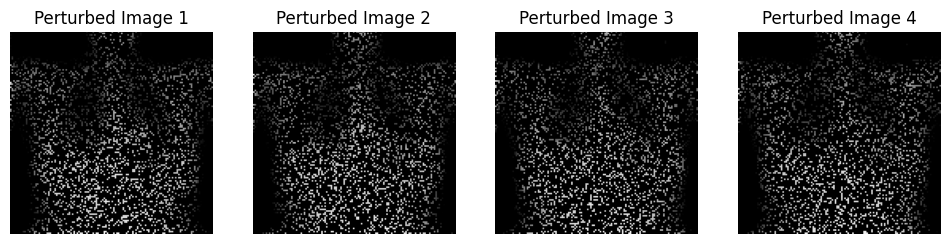

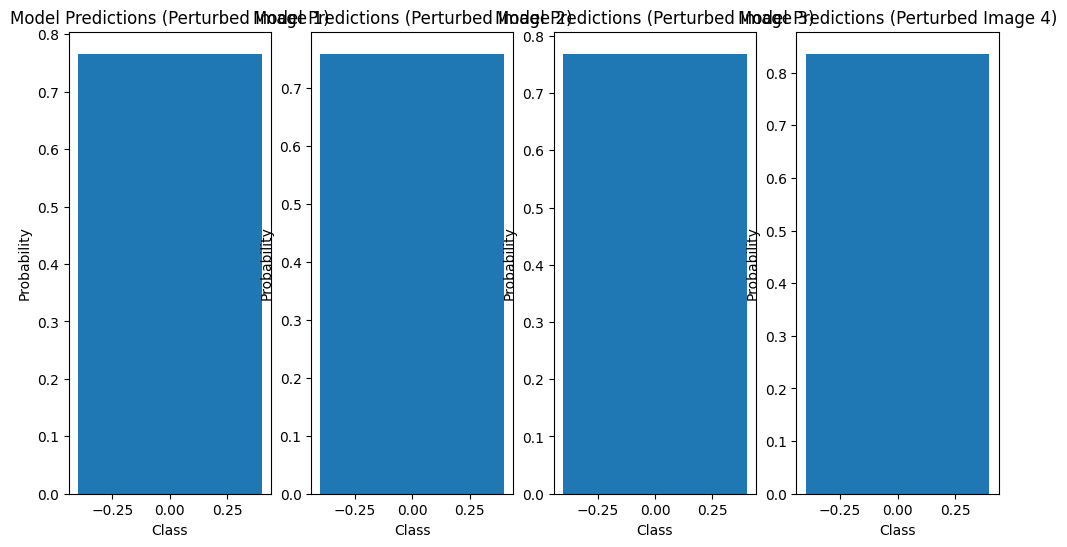

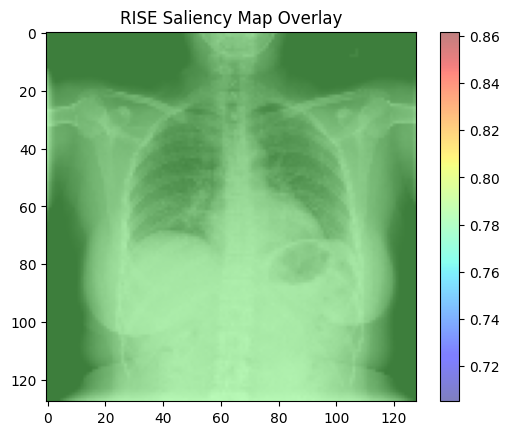

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load an example image for prediction
img_path = "Normal-998.png"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0  # Normalize the image

# Load your trained model
model = load_model("trainedmodel.h5")

# Function to generate perturbed images using RISE
def generate_perturbed_images(image, mask_size=8, n_masks=1000):
    perturbed_images = []
    for _ in range(n_masks):
        mask = np.random.choice([0, 1], size=(image.shape[0], image.shape[1]), p=[0.8, 0.2])
        masked_image = np.copy(image)
        masked_image[mask == 0] = 0
        perturbed_images.append(masked_image)
    return np.array(perturbed_images)

# Generate perturbed images using RISE
perturbed_images = generate_perturbed_images(img_array)

# Get model predictions for perturbed images
predictions = model.predict(perturbed_images)
print(predictions)

# Aggregate predictions to obtain saliency map
saliency_map = np.mean(predictions, axis=0)

# Resize saliency map to match input image size
saliency_map = resize(saliency_map, img_array.shape[:2], anti_aliasing=True)

# Plot the perturbed images
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(perturbed_images[i])
    plt.title(f"Perturbed Image {i+1}")
    plt.axis('off')
plt.show()

# Plot the model predictions for perturbed images
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.bar(range(len(predictions[i])), predictions[i])
    plt.title(f"Model Predictions (Perturbed Image {i+1})")
    plt.xlabel("Class")
    plt.ylabel("Probability")
plt.show()

# Plot the saliency map overlay on the input image
plt.imshow(img_array)
plt.imshow(saliency_map, cmap='jet', alpha=0.5)
plt.title("RISE Saliency Map Overlay")
plt.colorbar()
plt.show()


In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
import shap

# Load an example image for prediction
img_path =img_path
img = image.load_img(img_path, target_size=(128, 128))  # Adjust the target size based on your model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# print(img_array)

# Instantiate your CNN model (assuming you have already saved it)
# model = load_model("path_to_saved_model.h5")  # Load your saved model
# model.summary()

# Create an explainer object using the DeepExplainer for TensorFlow Keras models
explainer = shap.Explainer(model, img_array)

# Calculate SHAP values for the image
shap_values = explainer.shap_values(img_array)

# Plot the SHAP values
shap.image_plot(shap_values, img_array, show=False)
plt.title("SHAP Explanation")
plt.show()


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
import tensorflow as tf
import numpy as np

def layerwise_relevance_propagation(model, img_array):
    # Initialize relevance scores
    relevance_scores = np.zeros_like(img_array)

    # Forward pass
    layer_outputs = []
    input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    for layer in model.layers:
        input_tensor = layer(input_tensor)
        layer_outputs.append(input_tensor)

    # Backward pass (LRP)
    R = np.squeeze(input_tensor.numpy())  # Final prediction
    for i in range(len(model.layers) - 1, 0, -1):
        layer = model.layers[i]
        output_tensor = layer_outputs[i]
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights, biases = layer.get_weights()
            R = layerwise_relevance_propagation_conv(R, output_tensor.numpy(), weights)
        elif isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            R = layerwise_relevance_propagation_dense(R, output_tensor.numpy(), weights, biases)
        else:
            R = R * output_tensor.numpy() / (output_tensor.numpy().sum() + 1e-9)

    relevance_scores[0] = R

    return relevance_scores

# def layerwise_relevance_propagation_dense(R, A, W, b):
#     # Expand dimensions of the bias vector to match the shape of the activation matrix
#     b_expanded = np.expand_dims(b, axis=0)

#     # Calculate the relevance scores
#     Z = np.dot(A, W) + b_expanded + 1e-9
#     S = R / Z
#     C = np.dot(S, W.T)
#     R_new = A * C
#     return R_new

# def layerwise_relevance_propagation_dense(R, A, W, b):
#     # Transpose the weight matrix to align dimensions properly
#     W_transpose = np.transpose(W)

#     # Calculate the relevance scores
#     Z = np.dot(A, W_transpose) + b + 1e-9
#     S = R / Z
#     C = np.dot(S, W_transpose)
#     R_new = A * C
#     return R_new

def layerwise_relevance_propagation_dense(R, A, W, b):
    # Transpose the weight matrix to align dimensions properly
    W_transpose = np.transpose(W)

    # Calculate the relevance scores
    Z = np.dot(A, W_transpose) + b + 1e-9
    S = R / Z
    C = np.dot(S, W)  # Dot product without transposing W
    R_new = A * C
    return R_new




def layerwise_relevance_propagation_conv(R, A, W):
    Z = np.dot(A, W) + 1e-9
    S = R / Z
    C = np.dot(S, W.T)
    R_new = A * C
    return R_new

# def layerwise_relevance_propagation_dense(R, A, W, b):
#     Z = np.dot(A, W) + b + 1e-9
#     S = R / Z
#     C = np.dot(S, W.T)
#     R_new = A * C
#     return R_new


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load an example image for prediction
img_path = "Tuberculosis-71.png"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Instantiate your CNN model (assuming you have already saved it)
model = load_model("trainedmodel.h5")  # Load your saved model
model.summary()

# Calculate relevance scores for the image
relevance_scores = layerwise_relevance_propagation(model, img_array)

# Now you have the relevance scores for each pixel in the image


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 128, 128, 1)       28        
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 64, 64, 1)         0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 3)         30        
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 32, 32, 3)         0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 6)         168       
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 16, 16, 6)       

ValueError: operands could not be broadcast together with shapes (1,1536) (6,) 

In [ ]:
# class ImageSegmentation:
#     def __init__(self, input_shape):
#         self.input_shape = input_shape


#     def lung_segmentation(self, X):
#         if X.shape != self.input_shape:
#             X = X[:, :, 0]

#         # Equalize the image with CLAHE
#         X = exposure.equalize_adapthist(
#             X, kernel_size=None, clip_limit=0.01, nbins=256)

#         # Convert the image to grayscale if it's RGB
#         if X.ndim == 3:
#             X = rgb2gray(X)

#         # Create a binary threshold mask and apply it to the image
#         thresh = threshold_otsu(image=X)
#         binary = X > thresh
#         bw = closing(binary, square(3))  # Adjust the size of the square footprint as needed

#         # Clean up the borders
#         cleared = clear_border(bw)

#         # Label image regions
#         label_image = label(cleared)
#         image_label_overlay = label2rgb(
#         label_image, image=X, bg_label=0, bg_color=(0, 0, 0))

#         return image_label_overlay, label_image

#     def show_segmented_images(self,images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False,only_segmented=True):
#         '''
#         :Parameters
#             images (ndarray (n,)): Input data as a numpy array.
#             target (ndarray (n,)): Target data as a numpy array.
#             title (String): Title of the plot.
#             num_display (int): Number of images to display. Default is 16.
#             num_cols (int): Number of columns in the plot. Default is 4.
#             cmap (str): Color map for displaying images. Default is 'gray'.
#             random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
#         '''
#         # Determine the number of rows based on the num_cols parameter
#         n_cols = min(num_cols, num_display)
#         n_rows = int(np.ceil(num_display / n_cols))

#         n_images = min(num_display, len(images))
#         if random_mode:
#             random_indices = np.random.choice(
#                 len(images), num_display, replace=False)
#         else:
#             random_indices = np.arange(num_display)

#         fig, axes = plt.subplots(
#             nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
#         for i, ax in enumerate(axes.flatten()):
#             if i >= n_images:  # Check if the index exceeds the available number of images
#                 break
#             # Incase (Did PCA)
#             index = random_indices[i]
#             if len(images.shape) == 2:
#                 image = images[index].reshape((128, 128)).astype(int)
#             else:
#                 image = images[index]

#             image_label_overlay, label_image = self.lung_segmentation(
#                 image)
                
#             ax.imshow(
#                 label_image if only_segmented else image_label_overlay, cmap=cmap)
#             ax.set_title("Target: {}".format(target[index]))

#             # Add image index as text
#             ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
#                     fontsize=10, ha='center')

#         plt.suptitle(f"{title} (Displaying {num_display} Images)",
#                     fontsize=16, fontweight='bold')

#         fig.set_facecolor('white')
#         plt.tight_layout()  # Added to ensure proper spacing between subplots
#         return plt.show()
    
    
#     def show_segmented_image_from_path(self, image_path):
#         # Load image from file path
#         img = Image.open(image_path)

#         # Convert image to RGB mode if it's not already in RGB
#         if img.mode != 'RGB':
#             img = img.convert('RGB')

#         # Resize image if needed (assuming input_shape is (128, 128, 3))
#         img = img.resize((128, 128))

#         # Convert image to numpy array
#         img_array = np.array(img)

#         # Apply lung segmentation
#         image_label_overlay, _ = self.lung_segmentation(img_array)

#         # Display the segmented image
#         plt.imshow(image_label_overlay, cmap='gray')
#         plt.title("Lung Segmentation")
#         plt.tight_layout()
#         plt.savefig('LungSegemntation_output.png', bbox_inches='tight')
#         plt.show()


In [ ]:
# segmentation_model = ImageSegmentation(input_shape=(128, 128, 3))

# # Provide the image path to get lung segmentation
# lung_segmentation_result = segmentation_model.show_segmented_image_from_path(img_path)

In [18]:
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
class ImageSegmentation:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def lung_segmentation(self, X):
        if X.shape != self.input_shape:
            X = X[:, :, 0]

        # Equalize the image with CLAHE
        X = exposure.equalize_adapthist(
            X, kernel_size=None, clip_limit=0.01, nbins=256)

        # Create a binary threshold mask and apply it to the image
        thresh = threshold_otsu(image=X, nbins=256, hist=None)
        thresh = X > thresh
        bw = closing(X > thresh, square(1))

        # Clean up the borders
        cleared = clear_border(bw)

        # Label image regions
        label_image = label(cleared)
        image_label_overlay = label2rgb(
            label_image,
            image=X,
            bg_label=0,
            bg_color=(0, 0, 0))

        return image_label_overlay, label_image
    

    def show_segmented_images(self,images, target, title, num_display=16, num_cols=4, cmap='gray', random_mode=False,only_segmented=True):
        '''
        :Parameters
            images (ndarray (n,)): Input data as a numpy array.
            target (ndarray (n,)): Target data as a numpy array.
            title (String): Title of the plot.
            num_display (int): Number of images to display. Default is 16.
            num_cols (int): Number of columns in the plot. Default is 4.
            cmap (str): Color map for displaying images. Default is 'gray'.
            random_mode (bool): If True, display images randomly. If False, display the first num_display images. Default is False.
        '''
        # Determine the number of rows based on the num_cols parameter
        n_cols = min(num_cols, num_display)
        n_rows = int(np.ceil(num_display / n_cols))

        n_images = min(num_display, len(images))
        if random_mode:
            random_indices = np.random.choice(
                len(images), num_display, replace=False)
        else:
            random_indices = np.arange(num_display)

        fig, axes = plt.subplots(
            nrows=n_rows, ncols=n_cols, figsize=(20, 4*n_rows))
        for i, ax in enumerate(axes.flatten()):
            if i >= n_images:  # Check if the index exceeds the available number of images
                break
            # Incase (Did PCA)
            index = random_indices[i]
            if len(images.shape) == 2:
                image = images[index].reshape((128, 128)).astype(int)
            else:
                image = images[index]

            image_label_overlay, label_image = self.lung_segmentation(
                image)
                
            ax.imshow(
                label_image if only_segmented else image_label_overlay, cmap=cmap)
            ax.set_title("Target: {}".format(target[index]))

            # Add image index as text
            ax.text(0.5, -0.15, f'Image Index: {index}', transform=ax.transAxes,
                    fontsize=10, ha='center')

        plt.suptitle(f"{title} (Displaying {num_display} Images)",
                    fontsize=16, fontweight='bold')

        fig.set_facecolor('white')
        plt.tight_layout()  # Added to ensure proper spacing between subplots
        return plt.show()
    
    
    def show_segmented_image_from_path(self, image_path):
        # Load image from file path
        img = Image.open(image_path)

        # Preprocess the image (resize, convert to numpy array, etc.)
        img_array = np.array(img)  # Assuming img is a PIL Image
        # Additional preprocessing steps if needed...

        # Apply lung segmentation
        image_label_overlay, _ = self.lung_segmentation(img_array)

        # Display the segmented image
        plt.imshow(image_label_overlay, cmap='gray')
        plt.title("Lung Segmentation")
        plt.show()
        
        

        


1/1 [==============================] - 0s 33ms/step


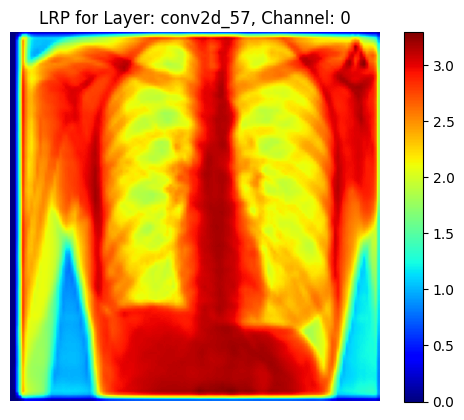

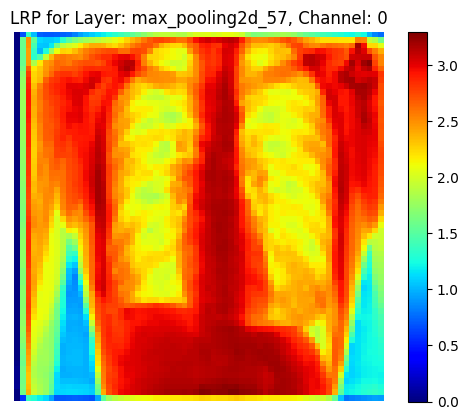

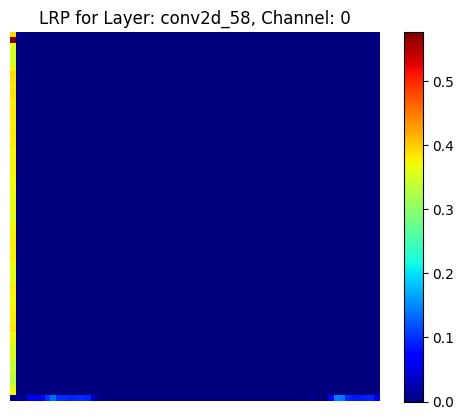

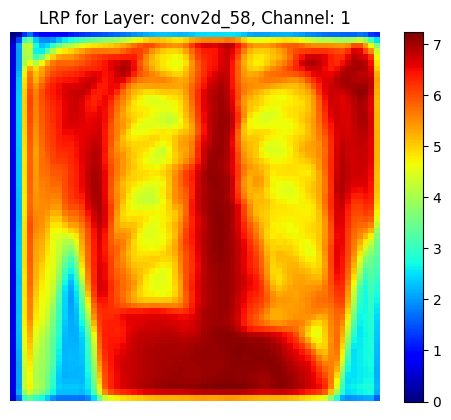

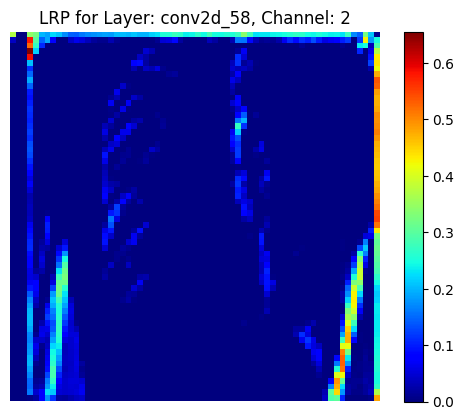

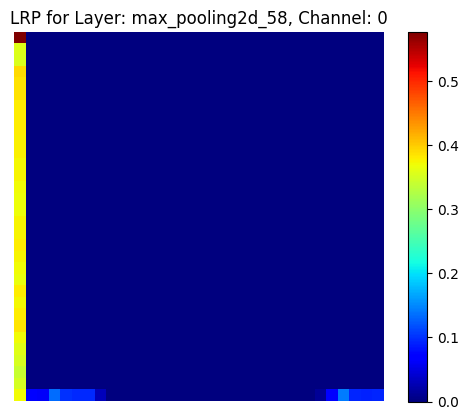

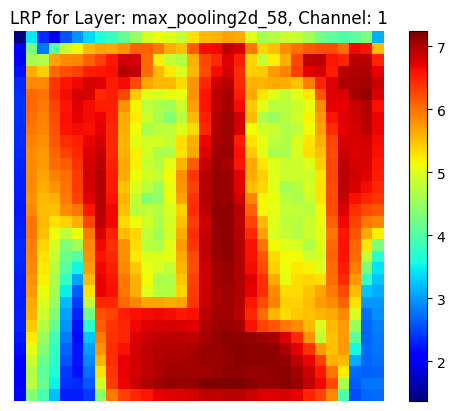

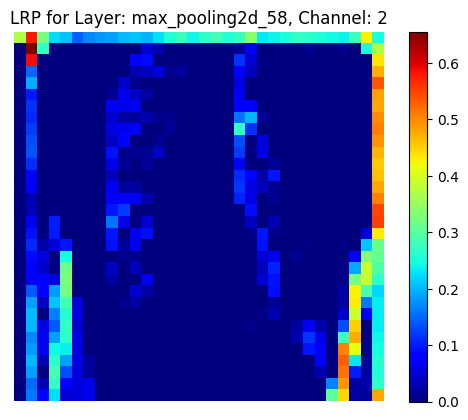

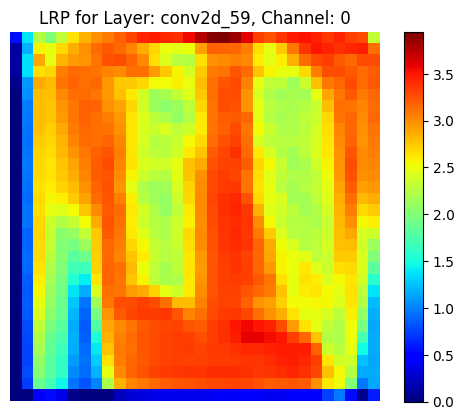

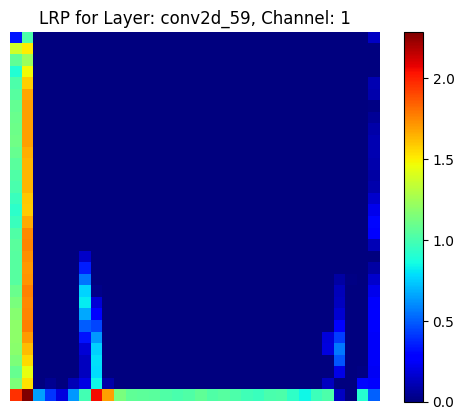

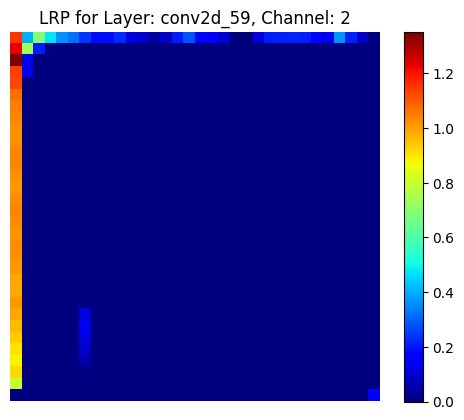

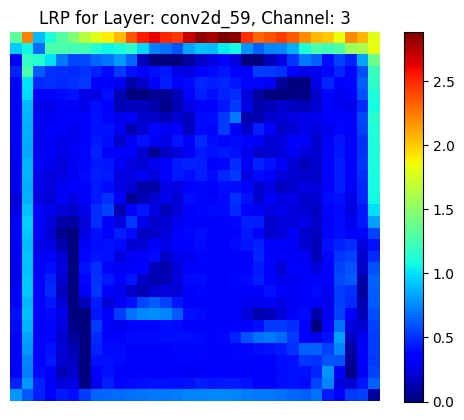

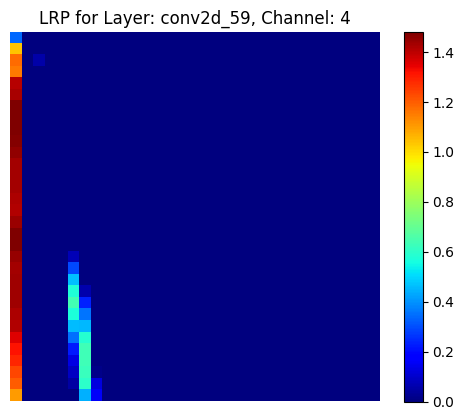

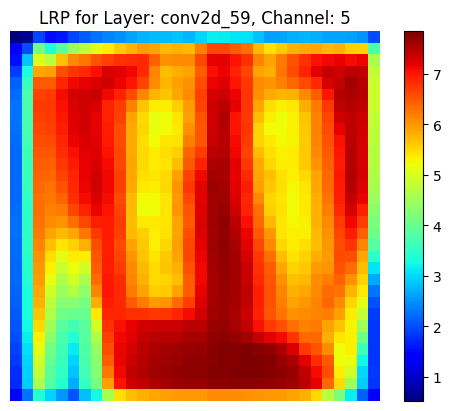

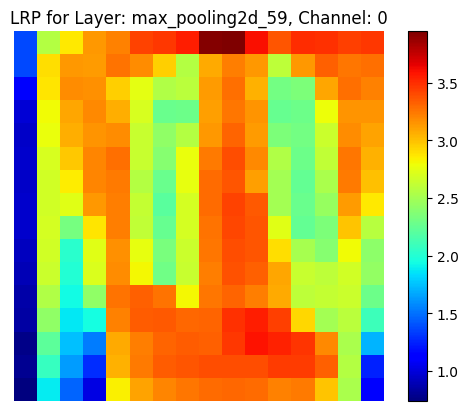

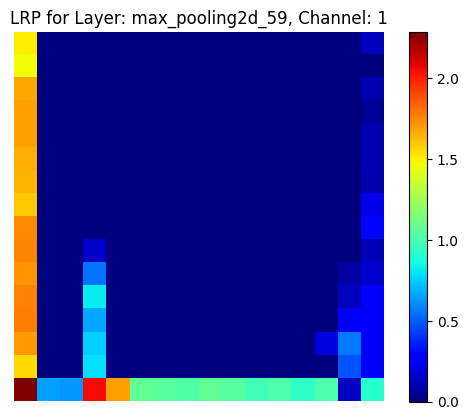

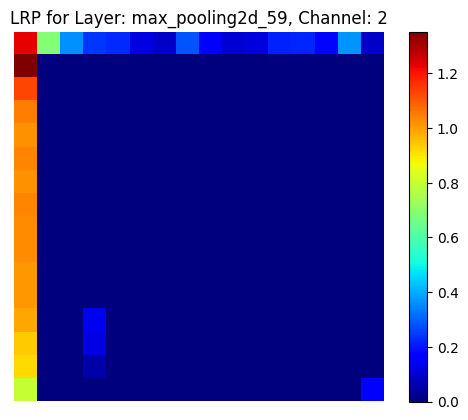

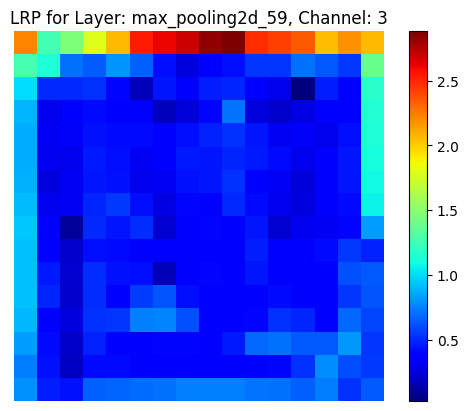

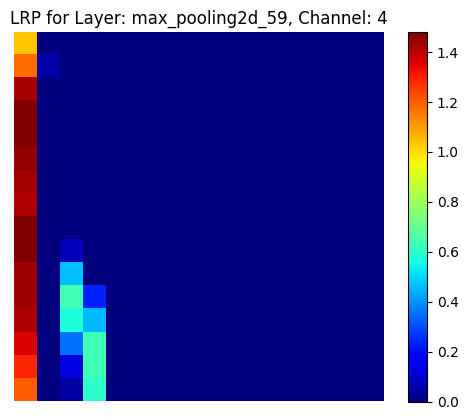

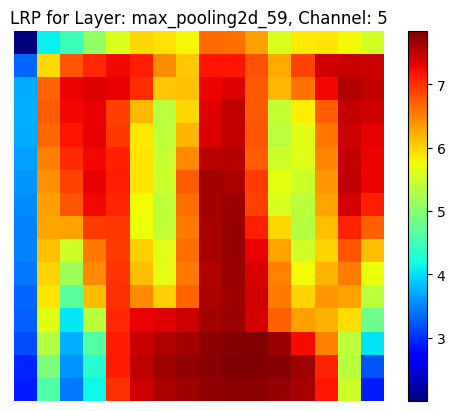

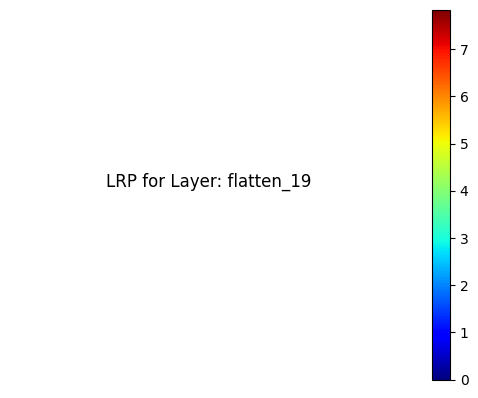

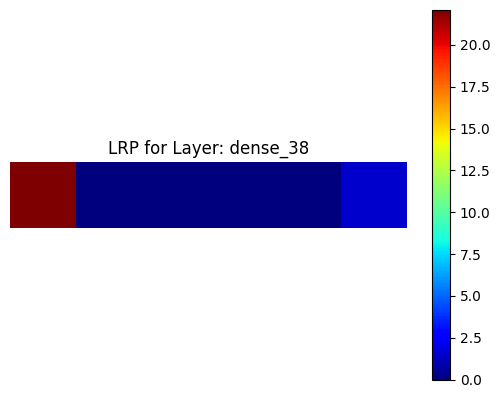

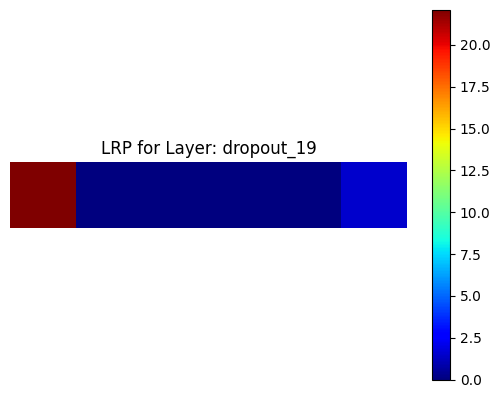

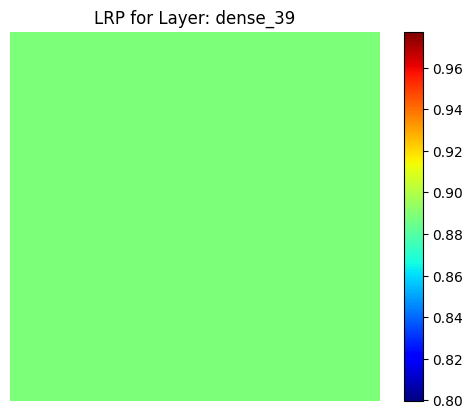

In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def compute_lrp_for_layer(model, img_array, layer_name):
    # Define a sub-model that outputs the activations of the specified layer
    sub_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Get the layer output
    layer_output = sub_model(img_array)
    
    # Compute the relevance using LRP rule
    relevance = layer_output * model.predict(img_array)
    return relevance

# Load your trained model
model = load_model("trainedmodel.h5")

# Load and preprocess your input image
img_path = r'C:\Users\prasa\Desktop\FYP\Tuberculosis-71.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

# Compute LRP for each layer
lrp_images = {}
layer_names = [layer.name for layer in model.layers]
for layer_name in layer_names:
    lrp_images[layer_name] = compute_lrp_for_layer(model, img_array, layer_name)

# Visualize LRP images for each layer
for layer_name, lrp_image in lrp_images.items():
    # Convert the KerasTensor to a NumPy array
    lrp_array = lrp_image.numpy()
    
    # If lrp_array has more than 2 dimensions, remove the batch dimension
    if len(lrp_array.shape) == 4:
        lrp_array = np.squeeze(lrp_array, axis=0)
    
    # Plot the LRP array
    if len(lrp_array.shape) == 3:  # Check if it's a multi-channel image
        for i in range(lrp_array.shape[-1]):
            plt.figure()
            plt.imshow(lrp_array[:, :, i], cmap='jet')  
            plt.title(f"LRP for Layer: {layer_name}, Channel: {i}")
            plt.axis("off")
            plt.colorbar()
            plt.show()
    else:
        plt.figure()
        plt.imshow(lrp_array, cmap='jet')  
        plt.title(f"LRP for Layer: {layer_name}")
        plt.axis("off")
        plt.colorbar()
        plt.show()


1/1 [==============================] - 0s 30ms/step


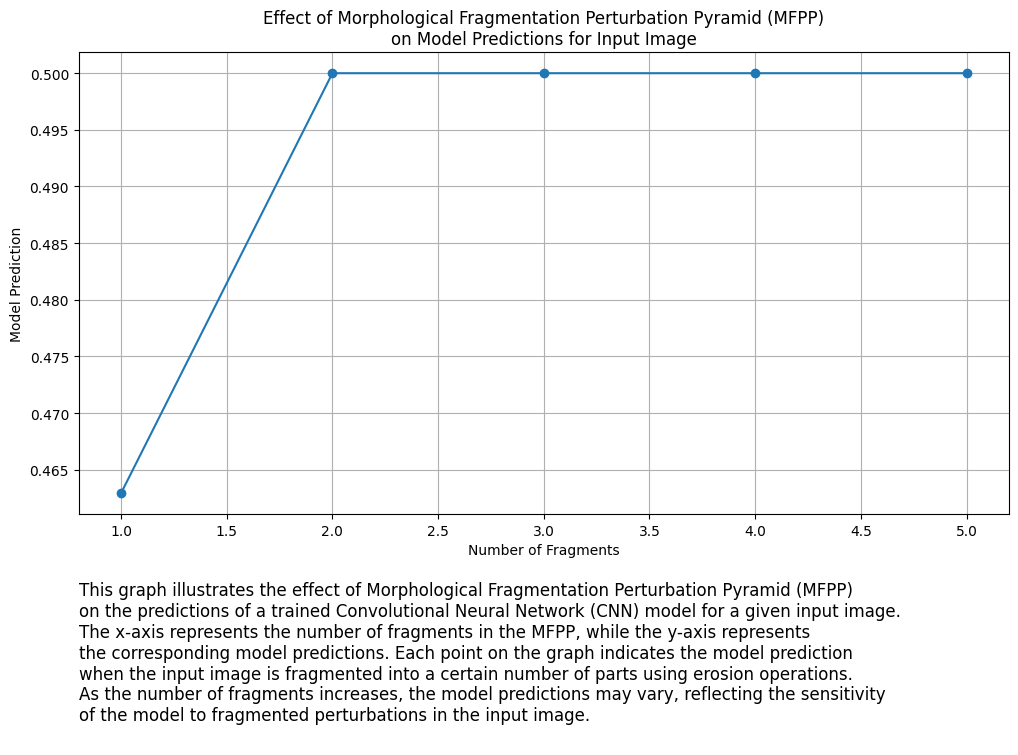

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
from sklearn.feature_extraction import image

def fragment_image(image, num_fragments):
    # Convert image to binary
    binary_image = image > np.mean(image)
    
    # Create a copy of the binary image
    fragmented_image = binary_image.copy()
    
    # Fragment the image by performing erosion iteratively
    for _ in range(num_fragments):
        fragmented_image = binary_erosion(fragmented_image)
    
    # Convert binary fragmented image back to float
    fragmented_image = fragmented_image.astype(float)
    
    return fragmented_image

def apply_mfpp(model, input_image, num_fragments):
    # Generate fragmented perturbations
    fragmented_images = [fragment_image(input_image, n) for n in range(1, num_fragments + 1)]
    
    # Perform prediction on perturbed images
    predictions = [model.predict(np.expand_dims(perturbed_img, axis=0))[0][0] for perturbed_img in fragmented_images]
    
    return predictions

# Example usage
# Load your trained model
model = load_model("trained_model.h5")

# Load and preprocess your input image
img_path = r'C:\Users\prasa\Desktop\FYP\Tuberculosis-71.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
input_image = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize the image

# Specify the number of fragments for MFPP
num_fragments = 5

# Apply MFPP
mfpp_predictions = apply_mfpp(model, input_image, num_fragments)

# Visualize the MFPP predictions
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_fragments + 1), mfpp_predictions, marker='o')
plt.xlabel("Number of Fragments")
plt.ylabel("Model Prediction")
plt.title("Effect of Morphological Fragmentation Perturbation Pyramid (MFPP)\n"
          "on Model Predictions for Input Image")
plt.grid(True)

# Detailed description below the plot
description = """
This graph illustrates the effect of Morphological Fragmentation Perturbation Pyramid (MFPP) 
on the predictions of a trained Convolutional Neural Network (CNN) model for a given input image. 
The x-axis represents the number of fragments in the MFPP, while the y-axis represents 
the corresponding model predictions. Each point on the graph indicates the model prediction 
when the input image is fragmented into a certain number of parts using erosion operations. 
As the number of fragments increases, the model predictions may vary, reflecting the sensitivity 
of the model to fragmented perturbations in the input image.
"""
plt.text(0, -0.3, description, horizontalalignment='left', verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)

plt.show()
